# AI for Redistricting Final Project

## Oregon Data Cleaning

@authors: vcle, bpuhani

All data retrieved in March 2025: <br>
[2020 Population data](https://redistrictingdatahub.org/dataset/oregon-block-pl-94171-2020-by-table/): based on the decennial census at the Census Block level on 2020 Census Redistricting Data

[2020 County data](https://redistrictingdatahub.org/dataset/oregon-county-pl-94171-2020/): from 2020 Census Redistricting Data (P.L. 94-171) Shapefiles

[2020 election data](https://redistrictingdatahub.org/dataset/vest-2020-oregon-precinct-and-election-results/):  VEST 2020 Oregon precinct and election results

[2021 State Senate District plan](https://redistrictingdatahub.org/dataset/2021-oregon-state-senate-adopted-plan/): 2021 Oregon State Senate Approved Plan


<!-- Commented out 2018 Election data for now

[2018 election data](https://redistrictingdatahub.org/dataset/vest-2018-oregon-precinct-and-election-results/)**:**  VEST 2018 Oregon precinct and election results

-->

In [44]:
# imports
import geopandas as gpd
import maup
from maup import smart_repair
import time
import warnings

import utilities

In [2]:
maup.progress.enabled = True

warnings.filterwarnings('ignore')

start_time = time.time()

## Import and Explore the Data

#### Description of the data or_pl2020_b:
* P1. Race
* P2. Hispanic or Latino, and Not Hispanic or Latino by Race
* P3. Race for the Population 18 Years and Over
* P4. Hispanic or Latino, and Not Hispanic or Latino by Race for the Population 18 Years and Over
* P5. Group Quarters Population by Major Group Quarters Type
* H1. Occupancy Status

Taken from the [Documentation](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/summary-file/2020Census_PL94_171Redistricting_StatesTechDoc_English.pdf)

We are using the following data:
* P2
* P4

In [3]:
# Paths to the data
population_path = "./or_data/or_pl2020_b/or_pl2020_p2_b.shp"
vap_path = "./or_data/or_pl2020_b/or_pl2020_p4_b.shp"
vest20_path = "./or_data/or_vest_20/or_vest_20.shp"
# vest18_path = "./or_data/or_vest_18/or_vest_18.shp" # currently not used
county_path = "./or_data/or_pl2020_cnty/or_pl2020_cnty.shp"
sen_path = "./or_data/or_sldu_2021/Senate_LC_Draft_2_-_Revised_.shp"

### Loading data
Loading the total population data

In [4]:
population_df = utilities.load_shapefile(population_path)

Loading shapefile from ./or_data/or_pl2020_b/or_pl2020_p2_b.shp...
Loading shapefile...
Shapefile data saved successfully to ./or_data/or_pl2020_b/or_pl2020_p2_b.shp.pkl.


Loading the voting age population data

In [5]:
vap_df = utilities.load_shapefile(vap_path)

Loading shapefile from ./or_data/or_pl2020_b/or_pl2020_p4_b.shp...
Loading shapefile...
Shapefile data saved successfully to ./or_data/or_pl2020_b/or_pl2020_p4_b.shp.pkl.


Loading the VEST 2020 election data

In [6]:
vest20_df = utilities.load_shapefile(vest20_path)

Loading shapefile from ./or_data/or_vest_20/or_vest_20.shp...
Loading shapefile...
Shapefile data saved successfully to ./or_data/or_vest_20/or_vest_20.shp.pkl.


Loading the County data

In [7]:
county_df = gpd.read_file(county_path)

Loading the approved 2021 State Senate District plan

In [8]:
sen_df = gpd.read_file(sen_path)

## Exploring the data
Column names of the data

In [9]:
print(population_df.columns)
print(vap_df.columns)
print(vest20_df.columns)
print(county_df.columns)
print(sen_df.columns)

Index(['GEOID20', 'SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'P0020001',
       'P0020002', 'P0020003', 'P0020004', 'P0020005', 'P0020006', 'P0020007',
       'P0020008', 'P0020009', 'P0020010', 'P0020011', 'P0020012', 'P0020013',
       'P0020014', 'P0020015', 'P0020016', 'P0020017', 'P0020018', 'P0020019',
       'P0020020', 'P0020021', 'P0020022', 'P0020023', 'P0020024', 'P0020025',
       'P0020026', 'P0020027', 'P0020028', 'P0020029', 'P0020030', 'P0020031',
       'P0020032', 'P0020033', 'P0020034', 'P0020035', 'P0020036', 'P0020037',
       'P0020038', 'P0020039', 'P0020040', 'P0020041', 'P0020042', 'P0020043',
       'P0020044', 'P0020045', 'P0020046', 'P0020047', 'P0020048', 'P0020049',
       'P0020050', 'P0020051', 'P0020052', 'P0020053', 'P0020054', 'P0020055',
       'P0020056', 'P0020057', 'P0020058', 'P0020059', 'P0020060', 'P0020061',
       'P0020062', 'P0020063', 'P0020064', 'P0020065', 'P0020066', 'P0020067',
       'P0020068', 'P0020069', 'P0020070', 'P0020071', 'P002

In [10]:
nr_of_districts = sen_df.shape[0]
print(f"Number of State Senate Seats in Oregon: {nr_of_districts}")

Number of State Senate Seats in Oregon: 30


The list of columns in the population data we are interested in:


In [28]:
pop_column_names = ['P0020001', 'P0020002', 'P0020005', 'P0020006', 'P0020007',
                    'P0020008', 'P0020009', 'P0020010', 'P0020011']

In [29]:
vap_column_names = ['P0040001', 'P0040002', 'P0040005', 'P0040006', 'P0040007',
                    'P0040008', 'P0040009', 'P0040010', 'P0040011']

## Cleaning the data
1. Change all the coordinate reference systems to the same one

In [11]:
population_df = population_df.to_crs(population_df.estimate_utm_crs())
vap_df = vap_df.to_crs(vap_df.estimate_utm_crs())
county_df = county_df.to_crs(county_df.estimate_utm_crs())
sen_df = sen_df.to_crs(sen_df.estimate_utm_crs())
vest20_df = vest20_df.to_crs(vest20_df.estimate_utm_crs())
# vest18_df = vest18_df.to_crs(vest18_df.estimate_utm_crs()) # currently not used

### Running MAUP Doctor

In [12]:
try:
    maup.doctor(population_df)
except Exception as e:
    print(f"Error in MAUP Doctor for population_df: {e}")

100%|██████████| 130807/130807 [02:21<00:00, 927.48it/s] 


True

In [13]:
try:
    maup.doctor(vap_df)
except Exception as e:
    print(f"Error in MAUP Doctor for vap_df: {e}")

100%|██████████| 130807/130807 [02:22<00:00, 921.03it/s] 


True

In [14]:
try:
    maup.doctor(county_df)
except Exception as e:
    print(f"Error in MAUP Doctor for county_df: {e}")

100%|██████████| 36/36 [00:00<00:00, 74.35it/s]


In [15]:
try:
    maup.doctor(sen_df)
except Exception as e:
    print(f"Error in MAUP Doctor for sen_df: {e}")

100%|██████████| 30/30 [00:00<00:00, 50.81it/s]


In [17]:
try:
    maup.doctor(vest20_df)
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for vest20_df: {e}\033[0m")

Error in MAUP Doctor for vest20_df: TopologyException: side location conflict at 490660.18003961764 4943064.1816223701. This can occur if the input geometry is invalid.


The maup doctor failed for the 2020 election data with a TopologyException.
It got recommended to use the `smart_repair` function with `snap_precision=8` to fix the TopologyException.

### Running MAUP Smart Repair for 2020 election data

first we run `smart_repair` with `snap_precision=8`, just to get rid of the TopologyException.

In [18]:
vest20_df_repaired_0 = smart_repair(vest20_df, snap_precision=8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 23006/23006 [00:13<00:00, 1757.40it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
2 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 10491it [1:22:11,  2.13it/s]                             
Gaps to fill: 100%|██████████| 379/379 [03:06<00:00,  2.03it/s]


In [20]:
# check if the repaired data is valid
try:
    maup.doctor(vest20_df_repaired_0)
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for repaired vest20_df: {e}\033[0m")

100%|██████████| 1331/1331 [00:05<00:00, 225.94it/s]


There are 2 holes.


Assign the population data to the precincts using MAUP and geometry intersection.

In [30]:
utilities.assign_population_data_to(
    vest20_df_repaired_0,
    population_df,
    vap_df,
    pop_column_names,
    vap_column_names
)

100%|██████████| 1331/1331 [00:15<00:00, 87.09it/s] 


Check if any people got missed by the assignment.

In [39]:
print("Total pop:\t", population_df['P0020001'].sum())
print("Actual pop:\t", vest20_df_repaired_0['P0020001'].sum())
print("Total vap:\t", vap_df['P0040001'].sum())
print("Actual vap:\t", vest20_df_repaired_0['P0040001'].sum())

Total pop:	 4237256
Actual pop:	 4237224.0
Total vap:	 3370652
Actual vap:	 3370625.0


We can see that for the population `32 people` are missing<br>
and for the voting age population `27 people` are missing.

## Checkpoint 0
* 2 holes
* rook adjacencies
* not fitted into counties
* missing 32 people in total population
* missing 27 people in voting age population

In [47]:
# create a checkpoint for the repaired data
utilities.checkpoint("repaired_vest20_0", vest20_df_repaired_0)

Checkpoint: repaired_vest20_0
Saving data...
Data saved successfully to checkpoints/repaired_vest20_0.pkl.


,STATE,COUNTY,PRECINCT,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREPHUN,G20PREOWRI,...,P0020011,P0040001,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011
0,41,Multnomah,4506,4506,2656,717,30,32,6,24,...,446.0,4734.0,403.0,2958.0,397.0,51.0,565.0,38.0,36.0,286.0
1,41,Multnomah,4409,4409,1613,473,24,22,11,15,...,276.0,4189.0,890.0,2421.0,370.0,39.0,237.0,32.0,13.0,187.0
2,41,Multnomah,4404,4404,8264,907,106,68,32,80,...,1511.0,15843.0,2276.0,9841.0,1317.0,123.0,993.0,173.0,76.0,1044.0
3,41,Multnomah,4502,4502,3948,482,49,32,9,27,...,427.0,5468.0,433.0,4094.0,195.0,33.0,378.0,19.0,36.0,280.0
4,41,Multnomah,4501,4501,9190,785,78,36,18,57,...,990.0,10539.0,454.0,8825.0,207.0,28.0,444.0,12.0,46.0,523.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,41,Clackamas,201,201,2656,1465,84,13,2,35,...,450.0,5330.0,494.0,4105.0,65.0,21.0,372.0,10.0,24.0,239.0
1327,41,Washington,435,435,2335,1608,82,18,8,49,...,389.0,4966.0,372.0,4116.0,14.0,15.0,186.0,13.0,18.0,232.0
1328,41,Washington,425,425,452,550,15,4,1,9,...,96.0,1206.0,73.0,1023.0,0.0,9.0,33.0,2.0,7.0,59.0
1329,41,Yamhill,13,Yamhill City & Rural,1091,2040,58,17,5,18,...,252.0,3599.0,187.0,3174.0,8.0,17.0,28.0,1.0,15.0,169.0


### Cleaning the data further
We will use `smart_repair` with:
* `snap_precision=10` to fix the holes and the adjacencies on a smaller grid.
* `nest_within_regions=county_df` to fit the precincts into the counties.
* `fill_gaps_threshold=None` to fill the gaps with the population data.

In [48]:
vest20_df_repaired_1 = smart_repair(
    vest20_df_repaired_0,
    snap_precision=10,
    nest_within_regions=county_df,
    fill_gaps_threshold = None
)

100%|██████████| 36/36 [00:00<00:00, 48.22it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████| 36/36 [00:00<00:00, 42.22it/s]


Identifying overlaps...


100%|██████████| 6949/6949 [00:03<00:00, 2090.94it/s]


Resolving overlaps and filling gaps...


100%|██████████| 36/36 [00:00<00:00, 38.59it/s]
Gaps to simplify in region 0: 21it [00:26,  1.28s/it]                        
Gaps to fill in region 0: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s]


1 gaps in region 1 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 2: 100%|██████████| 34/34 [00:06<00:00,  5.38it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 6: 100%|██████████| 34/34 [00:03<00:00, 10.47it/s]
Gaps to simplify in region 7: 40it [00:40,  1.01s/it]                        
Gaps to fill in region 13: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]
Gaps to simplify in region 14: 75it [00:22,  3.31it/s]                        
Gaps to fill in region 18: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]
Gaps to simplify in region 19: 73it [01:09,  1.05it/s]                        
Gaps to fill in region 21: 100%|██████████| 33/33 [00:02<00:00, 13.97it/s]
Gaps to simplify in region 22: 133it [00:18,  7.17it/s]                         
Gaps to fill in region 24: 100%|██████████| 53/53 [00:05<00:00,  9.29it/s]
Gaps to simplify in region 25: 377it [01:48,  3.49it/s]                         
Gaps to fill in region 30: 100%|██████████| 19/19 [00:01<00:00, 15.33it/s]


1 gaps in region 31 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 31: 75it [03:56,  3.16s/it]                        
Gaps to fill in region 31: 100%|██████████| 187/187 [00:26<00:00,  6.93it/s]
Gaps to simplify in region 32: 24it [12:56, 32.36s/it]                          
Gaps to fill in region 35: 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]


In [49]:
# check if the repaired data is valid
try:
    maup.doctor(vest20_df_repaired_1)
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for repaired vest20_df: {e}\033[0m")

100%|██████████| 1331/1331 [00:05<00:00, 249.21it/s]


There are 2 holes.


Assign the population data to the precincts (again) using MAUP and geometry intersection.

In [50]:
utilities.assign_population_data_to(
    vest20_df_repaired_1,
    population_df,
    vap_df,
    pop_column_names,
    vap_column_names
)

100%|██████████| 1331/1331 [00:14<00:00, 93.54it/s] 


Check if any people got missed by the assignment.

In [51]:
print("Total pop:\t", population_df['P0020001'].sum())
print("Actual pop:\t", vest20_df_repaired_1['P0020001'].sum())
print("Total vap:\t", vap_df['P0040001'].sum())
print("Actual vap:\t", vest20_df_repaired_1['P0040001'].sum())

Total pop:	 4237256
Actual pop:	 4237256.0
Total vap:	 3370652
Actual vap:	 3370652.0


## Checkpoint 1
* 2 holes
* rook adjacencies
* fitted into counties
* missing 0 people in total population
* missing 0 people in voting age population

In [52]:
# create a checkpoint for the repaired data
utilities.checkpoint("repaired_vest20_1", vest20_df_repaired_1)

Checkpoint: repaired_vest20_1
Saving data...
Data saved successfully to checkpoints/repaired_vest20_1.pkl.


,STATE,COUNTY,PRECINCT,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREPHUN,G20PREOWRI,...,P0020011,P0040001,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011
0,41,Multnomah,4506,4506,2656,717,30,32,6,24,...,446.0,4734.0,403.0,2958.0,397.0,51.0,565.0,38.0,36.0,286.0
1,41,Multnomah,4409,4409,1613,473,24,22,11,15,...,276.0,4189.0,890.0,2421.0,370.0,39.0,237.0,32.0,13.0,187.0
2,41,Multnomah,4404,4404,8264,907,106,68,32,80,...,1511.0,15843.0,2276.0,9841.0,1317.0,123.0,993.0,173.0,76.0,1044.0
3,41,Multnomah,4502,4502,3948,482,49,32,9,27,...,427.0,5468.0,433.0,4094.0,195.0,33.0,378.0,19.0,36.0,280.0
4,41,Multnomah,4501,4501,9190,785,78,36,18,57,...,990.0,10539.0,454.0,8825.0,207.0,28.0,444.0,12.0,46.0,523.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,41,Clackamas,201,201,2656,1465,84,13,2,35,...,450.0,5330.0,494.0,4105.0,65.0,21.0,372.0,10.0,24.0,239.0
1327,41,Washington,435,435,2335,1608,82,18,8,49,...,389.0,4966.0,372.0,4116.0,14.0,15.0,186.0,13.0,18.0,232.0
1328,41,Washington,425,425,452,550,15,4,1,9,...,96.0,1206.0,73.0,1023.0,0.0,9.0,33.0,2.0,7.0,59.0
1329,41,Yamhill,13,Yamhill City & Rural,1091,2040,58,17,5,18,...,252.0,3599.0,187.0,3174.0,8.0,17.0,28.0,1.0,15.0,169.0


### Cleaning the data even further
We will use `smart_repair` with:
* `min_rook_length=30` to remove the rook adjacencies.

In [53]:
vest20_df_repaired_2 = smart_repair(
    vest20_df_repaired_1,
    min_rook_length = 30
)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 2683/2683 [00:01<00:00, 2477.47it/s]


Resolving overlaps...
2 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|██████████| 5/5 [00:00<00:00, 820.67it/s]


## Checkpoint 2
* 2 holes
* queen adjacencies
* fitted into counties
* missing 0 people in total population
* missing 0 people in voting age population

In [57]:
# create a checkpoint for the repaired data
utilities.checkpoint("repaired_vest20_2", vest20_df_repaired_2)

Checkpoint: repaired_vest20_2
Saving data...
Data saved successfully to checkpoints/repaired_vest20_2.pkl.


,STATE,COUNTY,PRECINCT,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREPHUN,G20PREOWRI,...,P0020011,P0040001,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011
0,41,Multnomah,4506,4506,2656,717,30,32,6,24,...,446.0,4734.0,403.0,2958.0,397.0,51.0,565.0,38.0,36.0,286.0
1,41,Multnomah,4409,4409,1613,473,24,22,11,15,...,276.0,4189.0,890.0,2421.0,370.0,39.0,237.0,32.0,13.0,187.0
2,41,Multnomah,4404,4404,8264,907,106,68,32,80,...,1511.0,15843.0,2276.0,9841.0,1317.0,123.0,993.0,173.0,76.0,1044.0
3,41,Multnomah,4502,4502,3948,482,49,32,9,27,...,427.0,5468.0,433.0,4094.0,195.0,33.0,378.0,19.0,36.0,280.0
4,41,Multnomah,4501,4501,9190,785,78,36,18,57,...,990.0,10539.0,454.0,8825.0,207.0,28.0,444.0,12.0,46.0,523.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,41,Clackamas,201,201,2656,1465,84,13,2,35,...,450.0,5330.0,494.0,4105.0,65.0,21.0,372.0,10.0,24.0,239.0
1327,41,Washington,435,435,2335,1608,82,18,8,49,...,389.0,4966.0,372.0,4116.0,14.0,15.0,186.0,13.0,18.0,232.0
1328,41,Washington,425,425,452,550,15,4,1,9,...,96.0,1206.0,73.0,1023.0,0.0,9.0,33.0,2.0,7.0,59.0
1329,41,Yamhill,13,Yamhill City & Rural,1091,2040,58,17,5,18,...,252.0,3599.0,187.0,3174.0,8.0,17.0,28.0,1.0,15.0,169.0


In [54]:
# check if the repaired data is valid
try:
    maup.doctor(vest20_df_repaired_2)
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for repaired vest20_df: {e}\033[0m")

100%|██████████| 1331/1331 [00:04<00:00, 332.51it/s]


There are 2 holes.


In [55]:
utilities.assign_population_data_to(
    vest20_df_repaired_2,
    population_df,
    vap_df,
    pop_column_names,
    vap_column_names
)

100%|██████████| 1331/1331 [00:13<00:00, 97.53it/s] 


In [59]:
print("Total pop:\t", population_df['P0020001'].sum())
print("Actual pop:\t", vest20_df_repaired_2['P0020001'].sum())
print("Total vap:\t", vap_df['P0040001'].sum())
print("Actual vap:\t", vest20_df_repaired_2['P0040001'].sum())

Total pop:	 4237256
Actual pop:	 4237256.0
Total vap:	 3370652
Actual vap:	 3370652.0


### Check for NaN values

In [62]:
# print rows where there are NA values
vest20_df_repaired_2[vest20_df_repaired_2.isna().any(axis=1)]

,STATE,COUNTY,PRECINCT,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREPHUN,G20PREOWRI,...,P0020011,P0040001,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011
761,41,Josephine,29,West Colonial,38,92,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Place `West Colonial` in the county `Josephine` has `NaN` values for the population and voting age population. Although there are a number of votes.

We will replace the `NaN` values with `0`.

In [63]:
# Replace the NA value with 0
vest20_df_repaired_2.fillna(0, inplace=True)

## Adding the Approved State Senate Plan
### Renaming the columns for better usage

In [65]:
# copied from SC_MAUP.ipynb
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP',
                                        'G20PREDBID': 'G20PRED', 'G20PRERTRU': 'G20PRER', 'G20USSDHAR': 'G20USSD',
                                        'G20USSRGRA': 'G20USSR'}

In [66]:
vest20_df_repaired_2.columns

Index(['STATE', 'COUNTY', 'PRECINCT', 'NAME', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREPHUN', 'G20PREOWRI', 'G20USSDMER',
       'G20USSRPER', 'G20USSLDYE', 'G20USSGTAH', 'G20USSOWRI', 'G20ATGDROS',
       'G20ATGRCRO', 'G20ATGLHED', 'G20ATGOWRI', 'G20SOSDFAG', 'G20SOSRTHA',
       'G20SOSLMAR', 'G20SOSGPAR', 'G20SOSOWRI', 'G20TREDREA', 'G20TRERGUD',
       'G20TREIHEN', 'G20TRECMAR', 'G20TREOWRI', 'geometry', 'P0020001',
       'P0020002', 'P0020005', 'P0020006', 'P0020007', 'P0020008', 'P0020009',
       'P0020010', 'P0020011', 'P0040001', 'P0040002', 'P0040005', 'P0040006',
       'P0040007', 'P0040008', 'P0040009', 'P0040010', 'P0040011'],
      dtype='object')

In [67]:
vest20_df_repaired_2.rename(columns=rename_dict, inplace = True)

In [68]:
vest20_df_repaired_2.columns

Index(['STATE', 'COUNTY', 'PRECINCT', 'NAME', 'G20PRED', 'G20PRER',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREPHUN', 'G20PREOWRI', 'G20USSDMER',
       'G20USSRPER', 'G20USSLDYE', 'G20USSGTAH', 'G20USSOWRI', 'G20ATGDROS',
       'G20ATGRCRO', 'G20ATGLHED', 'G20ATGOWRI', 'G20SOSDFAG', 'G20SOSRTHA',
       'G20SOSLMAR', 'G20SOSGPAR', 'G20SOSOWRI', 'G20TREDREA', 'G20TRERGUD',
       'G20TREIHEN', 'G20TRECMAR', 'G20TREOWRI', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

Drop all the other (Not Republican or Democrat) candidates for all the elections.

In [69]:
vest20_df_repaired_2.drop(columns=[ 'G20PRELJOR','G20PREGHAW','G20PREPHUN','G20PREOWRI',  'G20USSLDYE', 'G20USSGTAH', 'G20USSOWRI', 'G20ATGLHED', 'G20ATGOWRI', 'G20SOSLMAR', 'G20SOSGPAR', 'G20SOSOWRI', 'G20TREIHEN', 'G20TRECMAR', 'G20TREOWRI'], inplace=True)
print(vest20_df_repaired_2.columns)

Index(['STATE', 'COUNTY', 'PRECINCT', 'NAME', 'G20PRED', 'G20PRER',
       'G20USSDMER', 'G20USSRPER', 'G20ATGDROS', 'G20ATGRCRO', 'G20SOSDFAG',
       'G20SOSRTHA', 'G20TREDREA', 'G20TRERGUD', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')


### Add the approved plan data

In [70]:
precincts_to_districts_assignment = maup.assign(vest20_df_repaired_2.geometry, sen_df.geometry)
vest20_df_repaired_2["SEND"] = precincts_to_districts_assignment

100%|██████████| 30/30 [00:01<00:00, 25.83it/s]


In [71]:
vest20_df_repaired_2.head()

,STATE,COUNTY,PRECINCT,NAME,G20PRED,G20PRER,G20USSDMER,G20USSRPER,G20ATGDROS,G20ATGRCRO,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEND
0,41,Multnomah,4506,4506,2656,717,2548,648,2486,693,...,4734.0,403.0,2958.0,397.0,51.0,565.0,38.0,36.0,286.0,22
1,41,Multnomah,4409,4409,1613,473,1605,403,1566,424,...,4189.0,890.0,2421.0,370.0,39.0,237.0,32.0,13.0,187.0,21
2,41,Multnomah,4404,4404,8264,907,8048,882,7917,959,...,15843.0,2276.0,9841.0,1317.0,123.0,993.0,173.0,76.0,1044.0,21
3,41,Multnomah,4502,4502,3948,482,3850,472,3740,516,...,5468.0,433.0,4094.0,195.0,33.0,378.0,19.0,36.0,280.0,22
4,41,Multnomah,4501,4501,9190,785,9001,830,8631,957,...,10539.0,454.0,8825.0,207.0,28.0,444.0,12.0,46.0,523.0,22


get a unique set of all the districts in the `"SEND"` column

In [72]:
print(set(vest20_df_repaired_2["SEND"]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


Explore the sen_df data

In [73]:
sen_df.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV,TOTALHISP,WHITENH,BLACKNH,AIANNH,ASIANNH,HPINH,OTHERNH,MLTMNNH,geometry
0,District 1,D1,1,2127829120,142212,970,8701,119379,946,7136,2218,399,2851,582,"POLYGON ((373494.752 4726860.593, 372767.887 4..."
1,District 2,D2,2,1015926656,141786,544,11357,117097,1280,5707,2537,498,2661,649,"POLYGON ((417445.343 4700401.288, 417451.062 4..."
2,District 3,D3,3,101601152,142502,1260,20776,106432,2190,4351,3936,868,3142,807,"POLYGON ((504659.233 4685921.052, 504610.705 4..."
3,District 4,D4,4,1627761792,142435,1193,16000,107187,3331,4627,6958,680,2679,973,"POLYGON ((493964.413 4872248.265, 493955.959 4..."
4,District 5,D5,5,1675345024,140391,-851,10746,114408,1126,7399,2753,520,2726,713,"POLYGON ((409288.586 4958998.171, 409324.577 4..."


print the unique values of the `"DISTRICT"` column

In [74]:
print(set(sen_df["DISTRICT"]))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}


In Oregon, the states are good numbered, only starting with 1 instead of 0 so lets fix that and use the shortname: D1 etc.

In [75]:
# rename the districts with the matching shortname from the sen_df
for i in range(len(vest20_df_repaired_2)):
    vest20_df_repaired_2.at[i, "SEND"] = sen_df.at[int(vest20_df_repaired_2.at[i, "SEND"]), "SHORTNAME"]

In [77]:
print(set(sen_df["SHORTNAME"]))
print(set(vest20_df_repaired_2["SEND"]))

{'D1', 'D25', 'D12', 'D30', 'D21', 'D6', 'D8', 'D23', 'D5', 'D18', 'D26', 'D24', 'D7', 'D17', 'D3', 'D20', 'D14', 'D4', 'D11', 'D13', 'D2', 'D27', 'D28', 'D9', 'D15', 'D19', 'D29', 'D16', 'D10', 'D22'}
{'D1', 'D25', 'D12', 'D21', 'D6', 'D8', 'D23', 'D26', 'D5', 'D18', 'D24', 'D7', 'D17', 'D3', 'D20', 'D14', 'D4', 'D11', 'D13', 'D2', 'D27', 'D28', 'D10', 'D9', 'D15', 'D19', 'D29', 'D16', 'D30', 'D22'}


It worked :)

In [79]:
vest20_df_repaired_2.columns

Index(['STATE', 'COUNTY', 'PRECINCT', 'NAME', 'G20PRED', 'G20PRER',
       'G20USSDMER', 'G20USSRPER', 'G20ATGDROS', 'G20ATGRCRO', 'G20SOSDFAG',
       'G20SOSRTHA', 'G20TREDREA', 'G20TRERGUD', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'SEND'],
      dtype='object')

## Checkpoint 3
* 2 holes
* queen adjacencies
* fitted into counties
* missing 0 people in total population
* missing 0 people in voting age population
* added the approved plan data

In [80]:
# create a checkpoint for the repaired data
vest20_df_repaired_3 = vest20_df_repaired_2.copy()
utilities.checkpoint("repaired_vest20_3", vest20_df_repaired_3)

Checkpoint: repaired_vest20_3
Saving data...
Data saved successfully to checkpoints/repaired_vest20_3.pkl.


,STATE,COUNTY,PRECINCT,NAME,G20PRED,G20PRER,G20USSDMER,G20USSRPER,G20ATGDROS,G20ATGRCRO,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEND
0,41,Multnomah,4506,4506,2656,717,2548,648,2486,693,...,4734.0,403.0,2958.0,397.0,51.0,565.0,38.0,36.0,286.0,D23
1,41,Multnomah,4409,4409,1613,473,1605,403,1566,424,...,4189.0,890.0,2421.0,370.0,39.0,237.0,32.0,13.0,187.0,D22
2,41,Multnomah,4404,4404,8264,907,8048,882,7917,959,...,15843.0,2276.0,9841.0,1317.0,123.0,993.0,173.0,76.0,1044.0,D22
3,41,Multnomah,4502,4502,3948,482,3850,472,3740,516,...,5468.0,433.0,4094.0,195.0,33.0,378.0,19.0,36.0,280.0,D23
4,41,Multnomah,4501,4501,9190,785,9001,830,8631,957,...,10539.0,454.0,8825.0,207.0,28.0,444.0,12.0,46.0,523.0,D23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,41,Clackamas,201,201,2656,1465,2511,1478,2377,1552,...,5330.0,494.0,4105.0,65.0,21.0,372.0,10.0,24.0,239.0,D13
1327,41,Washington,435,435,2335,1608,2268,1596,2128,1695,...,4966.0,372.0,4116.0,14.0,15.0,186.0,13.0,18.0,232.0,D13
1328,41,Washington,425,425,452,550,441,541,419,539,...,1206.0,73.0,1023.0,0.0,9.0,33.0,2.0,7.0,59.0,D13
1329,41,Yamhill,13,Yamhill City & Rural,1091,2040,1104,1960,1033,1985,...,3599.0,187.0,3174.0,8.0,17.0,28.0,1.0,15.0,169.0,D12


<Axes: >

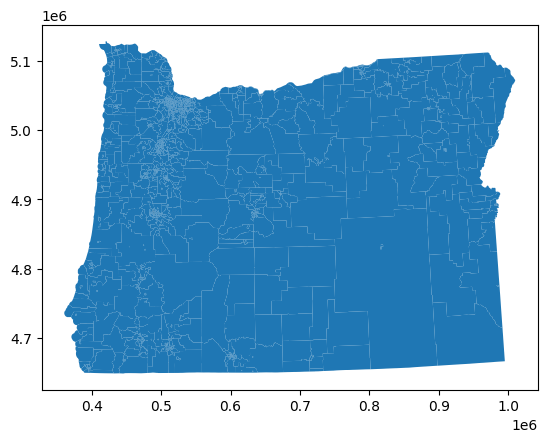

In [81]:
vest20_df_repaired_3.plot()